<a href="https://colab.research.google.com/github/pnperl/blank-app/blob/main/Shared_StockReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter one or more stock symbols (comma-separated, e.g., RELIANCE.NS, TCS.NS): CDSL.ns,reliance.ns
Enter historical data period (e.g., 6mo, 1y, 3mo): 10y


[*********************100%***********************]  2 of 2 completed


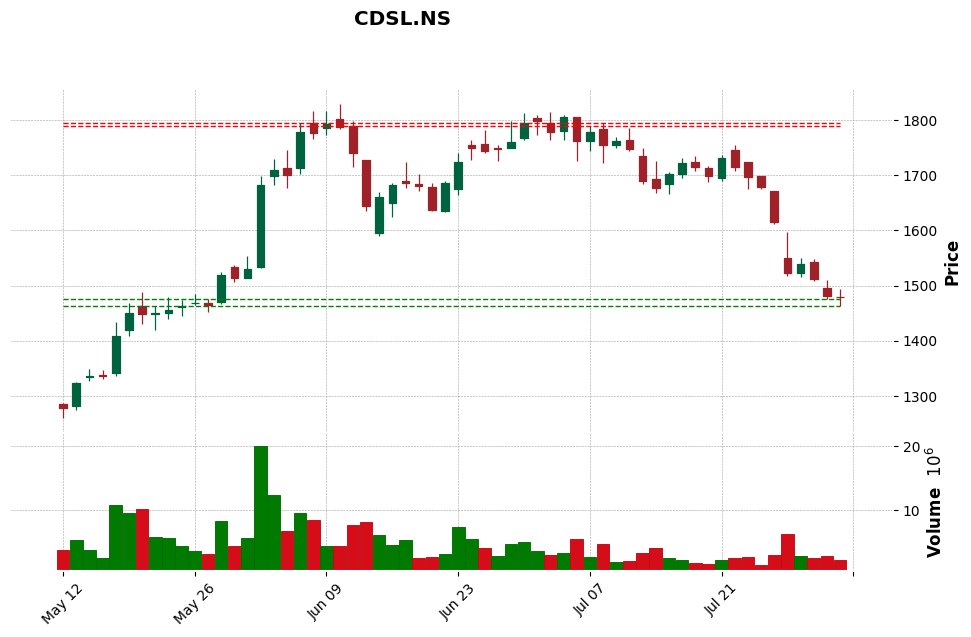

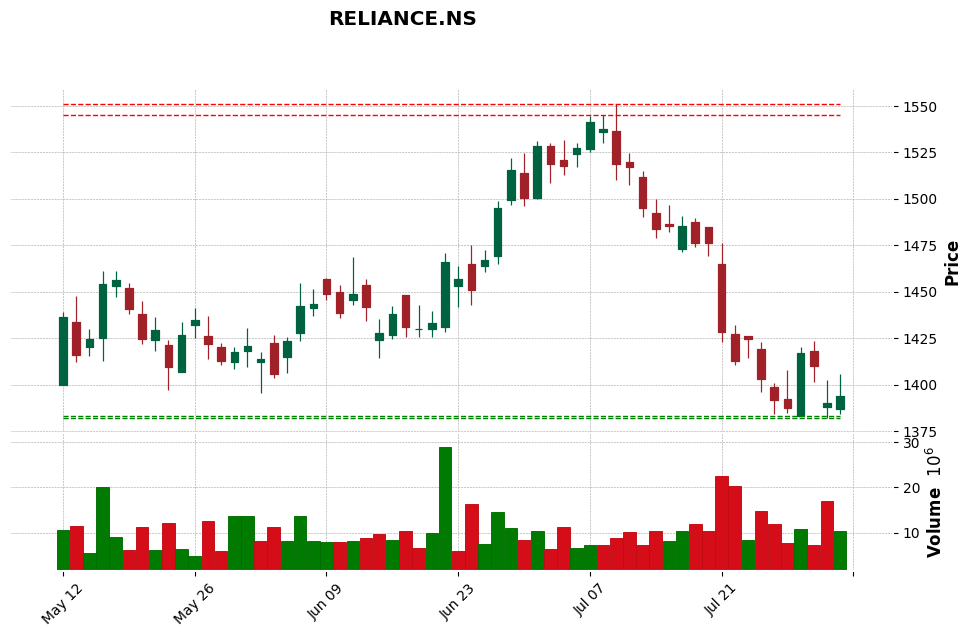

In [ ]:
# Required Libraries
!pip install -q yfinance mplfinance tqdm

import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from IPython.display import display, HTML
from tqdm import tqdm
import warnings

# Suppress FutureWarning from yfinance
warnings.filterwarnings('ignore', category=FutureWarning)

# Function to calculate technical indicators
def calculate_indicators(df):
    if df.empty or len(df) < 60 or not all(col in df for col in ['Open', 'High', 'Low', 'Close', 'Volume']):
        return pd.DataFrame()

    df = df.dropna().copy()  # Ensure no NaN values in required columns

    # Moving Averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA100'] = df['Close'].rolling(window=100).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()

    # EMA and MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    df['BB_Mid'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Mid'] + (2 * df['BB_Std'])
    df['BB_Lower'] = df['BB_Mid'] - (2 * df['BB_Std'])

    # RSI
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic
    low14 = df['Low'].rolling(14).min()
    high14 = df['High'].rolling(14).max()
    df['Stochastic'] = 100 * (df['Close'] - low14) / (high14 - low14)

    # Stochastic RSI
    rsi_min = df['RSI'].rolling(14).min()
    rsi_max = df['RSI'].rolling(14).max()
    df['StochRSI'] = 100 * (df['RSI'] - rsi_min) / (rsi_max - rsi_min)

    # CCI (Vectorized)
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(20).mean()
    mad = (tp - sma).abs().rolling(20).mean()
    df['CCI'] = (tp - sma) / (0.015 * mad)

    # Bull/Bear Power
    ema13 = df['Close'].ewm(span=13, adjust=False).mean()
    df['BullPower'] = df['High'] - ema13
    df['BearPower'] = df['Low'] - ema13

    # ADX
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift()),
        np.abs(df['Low'] - df['Close'].shift())
    ])
    df['+DM'] = np.where((df['High'] - df['High'].shift()) > (df['Low'].shift() - df['Low']),
                          np.maximum(df['High'] - df['High'].shift(), 0), 0)
    df['-DM'] = np.where((df['Low'].shift() - df['Low']) > (df['High'] - df['High'].shift()),
                          np.maximum(df['Low'].shift() - df['Low'], 0), 0)
    tr14 = df['TR'].rolling(14).sum()
    plus_dm14 = df['+DM'].rolling(14).sum()
    minus_dm14 = df['-DM'].rolling(14).sum()
    plus_di14 = 100 * (plus_dm14 / tr14)
    minus_di14 = 100 * (minus_dm14 / tr14)
    dx = 100 * np.abs(plus_di14 - minus_di14) / (plus_di14 + minus_di14)
    df['ADX'] = dx.rolling(14).mean()

    # EMA Crossover Signals
    df['EMA_signal'] = np.where((df['EMA12'] > df['EMA26']) &
                                (df['EMA12'].shift() <= df['EMA26'].shift()), 1, 0)
    df['EMA_signal_type'] = df['EMA_signal'].map({1: 'Bullish', 0: np.nan})

    return df

def get_support_resistance(df):
    recent = df.tail(20).copy()
    if recent.empty or len(recent) < 5:
        return np.array([]), np.array([])
    low_col = recent['Low'].dropna()
    high_col = recent['High'].dropna()
    support = low_col.nsmallest(2).values
    resistance = high_col.nlargest(2).values
    return support, resistance

def is_volume_breakout(df, window=20, threshold=1.5):
    if df.empty or len(df) < window + 1:
        return False
    avg_vol = df['Volume'].rolling(window=window).mean().iloc[-1]
    curr_vol = df['Volume'].iloc[-1]
    return curr_vol > threshold * avg_vol

def plot_candlestick_with_sr(df, support, resistance, ticker):
    df60 = df[-60:].copy() if len(df) >= 60 else df.copy()
    if df60.empty or len(df60) < 2:
        print(f"⚠️ Not enough data to plot for {ticker}. Skipping candlestick chart.")
        return

    apds = []
    valid_support = [s for s in support if not np.isnan(s)]
    valid_resistance = [r for r in resistance if not np.isnan(r)]
    for s in valid_support:
        apds.append(mpf.make_addplot([s]*len(df60), color='g', linestyle='--', width=1, panel=0, ylabel='Support'))
    for r in valid_resistance:
        apds.append(mpf.make_addplot([r]*len(df60), color='r', linestyle='--', width=1, panel=0, ylabel='Resistance'))

    try:
        mpf.plot(df60, type='candle', style='charles', addplot=apds, volume=True,
                 title=ticker, figratio=(16,9), figscale=1.2)
    except Exception as e:
        print(f"⚠️ Plotting failed for {ticker}: {e}")

def get_technical_summary(ticker, df, period="6mo"):
    if df.empty or len(df.dropna()) < 60:
        display(HTML(f"<p style='color:red;'>⚠️ No sufficient data found for {ticker}. Please check the symbol and try again.</p>"))
        return

    df = calculate_indicators(df)
    if df.empty:
        display(HTML(f"<p style='color:red;'>⚠️ Failed to calculate indicators for {ticker}. Insufficient data.</p>"))
        return

    last = df.iloc[-1]
    support, resistance = get_support_resistance(df)

    report = [f"<h2 style='color:#2c3e50;'>📊 Technical Analysis Report — {ticker}</h2>"]
    report.append("<p>This report includes key moving averages, momentum indicators, support/resistance levels, trade signals, and AI-based summary.</p>")

    report.append("<h3>📌 Latest Price Data</h3><ul>")
    for key in ['Open', 'High', 'Low', 'Close']:
        report.append(f"<li>{key}: {last[key]:.2f}</li>")
    report.append("</ul>")

    report.append("<h3 style='color:#27ae60;'>🚀 TECHNICAL VERDICT: Outlook & Strategy</h3>")
    logic = []
    if last['Close'] > last['MA50']: logic.append("Price above MA50 (bullish trend)")
    if last['RSI'] > 60: logic.append("RSI > 60 (positive momentum)")
    if last['MACD'] > last['MACD_Signal']: logic.append("MACD bullish crossover")
    if last['ADX'] > 20: logic.append("ADX > 20 (strong trend)")
    if is_volume_breakout(df): logic.append("Volume breakout detected")

    rating = min(5, len(logic))
    stars = '⭐' * rating + '✩' * (5 - rating)
    outlook_text = "Strongly Bullish" if rating >= 4 else "Neutral to Bullish" if rating >= 2 else "Sideways / Weak"
    strategy_text = "Buy on dips or breakout opportunities" if rating >= 4 else "Watch for confirmation" if rating >= 2 else "Avoid for now"

    report.append(f"<p><b>Outlook:</b> {outlook_text}</p><p><b>Strategy:</b> {strategy_text}</p><ul>")
    for item in logic:
        report.append(f"<li>{item}</li>")
    report.append("</ul>")

    report.append("<h3>📈 Trend & Moving Averages</h3><ul>")
    for ma in ['MA5', 'MA10', 'MA20', 'MA50', 'MA100', 'MA200']:
        if ma in df.columns and not pd.isna(last[ma]):
            report.append(f"<li>{ma}: {last[ma]:.2f}</li>")
    if not pd.isna(last['BB_Upper']):
        report.append(f"<li>Bollinger Bands: Upper {last['BB_Upper']:.2f}, Lower {last['BB_Lower']:.2f}</li>")
    report.append("</ul><p><b>Verdict:</b> Price above MAs → confirms bullish alignment.</p>")

    report.append("<h3>⚡ Momentum Indicators</h3><ul>")
    for m in ['RSI', 'Stochastic', 'StochRSI', 'MACD', 'MACD_Signal', 'CCI', 'BullPower', 'BearPower', 'ADX']:
        if m in last and not pd.isna(last[m]):
            report.append(f"<li>{m}: {last[m]:.2f}</li>")
    report.append("</ul><p><b>Verdict:</b> Momentum strong, some overbought signs (watch RSI).</p>")

    report.append("<h3>🏹 Support & Resistance</h3><ul>")
    for i, s in enumerate(support, 1):
        if not np.isnan(s):
            report.append(f"<li>Support {i}: {s:.2f}</li>")
    for i, r in enumerate(resistance, 1):
        if not np.isnan(r):
            report.append(f"<li>Resistance {i}: {r:.2f}</li>")
    report.append("</ul><p><b>Verdict:</b> Price between strong S/R zones. Watch for breakout.</p>")

    report.append("<h3>🔁 EMA Crossover Signal</h3><ul>")
    if df['EMA_signal'].iloc[-1] == 1:
        report.append("<li>✅ Bullish EMA crossover (EMA12 crossed above EMA26)</li>")
        report.append("</ul><p><b>Verdict:</b> Fresh bullish signal</p>")
    elif df['EMA12'].iloc[-1] < df['EMA26'].iloc[-1] and df['EMA12'].iloc[-2] >= df['EMA26'].iloc[-2]:
        report.append("<li>❌ Bearish EMA crossunder (EMA12 fell below EMA26)</li>")
        report.append("</ul><p><b>Verdict:</b> Possible downtrend setup</p>")
    else:
        report.append("<li>⏸️ No new EMA crossover signal</li>")
        report.append("</ul><p><b>Verdict:</b> No crossover confirmation</p>")

    insight = ("✅ Strong technical alignment — ideal for bullish trades." if rating >= 4 else
               "⚠️ Watch and wait for confirmation." if rating >= 2 else
               "❌ Risk of sideways/weak price action.")
    report.append("<h3>🧠 Final AI-Based Insight</h3>")
    report.append(f"<p>{insight}</p><p><b>⭐ AI Rating:</b> {stars}</p>")

    display(HTML("<div style='font-family:Arial; font-size:15px;'>" + "\n".join(report) + "</div>"))
    display(HTML("""
    <style>@media print { #print-btn { display: none; } }</style>
    <div id='print-btn'><button onclick="window.print()" style="padding:10px 20px; font-size:16px; background:#3498db; color:#fff; border:none; border-radius:5px;">🖨️ Export Report as PDF</button></div>
    """))

    plot_candlestick_with_sr(df, support, resistance, ticker)

def run_batch_analysis(symbols, period="6mo"):
    try:
        # Batch download data for all symbols
        data = yf.download(symbols, period=period, group_by='ticker', threads=True)
        if data.empty:
            display(HTML("<p style='color:red;'>⚠️ No data retrieved for any symbols. Please check the symbols and try again.</p>"))
            return

        for sym in tqdm(symbols, desc="Analyzing Stocks", file=open('/dev/null', 'w')):  # Suppress tqdm output
            display(HTML(f"<h3>{'='*80}</h3><p>🔍 Running Technical Analysis for: {sym}</p><h3>{'='*80}</h3>"))
            if sym in data.columns.levels[0]:
                df = data[sym].copy()
                df.columns = [col.lower().capitalize() for col in df.columns]
                get_technical_summary(sym, df, period)
            else:
                display(HTML(f"<p style='color:red;'>⚠️ No data available for {sym}. Skipping.</p>"))
    except Exception as e:
        display(HTML(f"<p style='color:red;'>⚠️ Error during batch download: {e}</p>"))
        # Fallback to individual downloads
        for sym in tqdm(symbols, desc="Analyzing Stocks (Fallback)", file=open('/dev/null', 'w')):
            display(HTML(f"<h3>{'='*80}</h3><p>🔍 Running Technical Analysis for: {sym}</p><h3>{'='*80}</h3>"))
            try:
                df = yf.Ticker(sym).history(period=period)
                get_technical_summary(sym, df, period)
            except Exception as e:
                display(HTML(f"<p style='color:red;'>⚠️ Error processing {sym}: {e}</p>"))

# User Input & Batch Execution
symbols = input("Enter one or more stock symbols (comma-separated, e.g., RELIANCE.NS, TCS.NS): ")
period = input("Enter historical data period (e.g., 6mo, 1y, 3mo): ") or "6mo"
symbol_list = [s.strip().upper() for s in symbols.split(',') if s.strip()]
if not symbol_list:
    display(HTML("<p style='color:red;'>⚠️ No valid symbols provided. Please enter at least one symbol.</p>"))
else:
    run_batch_analysis(symbol_list, period)